In [2]:
import pandas as pd
from pygam import LinearGAM, s, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt
from pygam.terms import SplineTerm

pitch = pd.read_excel("reduced_delanteros.xlsx")

numeric_vars = ['Transfer_value', 'Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC', 'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions', 'GCA_BC', 'Yellow_cards', 'Red_cards']
pitch[numeric_vars] = StandardScaler().fit_transform(pitch[numeric_vars])

In [3]:
ind_vars = ['Exp_contr', 'Age', 'Minutes_pl', 'Minutes_pl_BC',
       'NP_goals', 'Pen_goals', 'Pen_goals_BC', 'Assists', 'Interceptions',
       'GCA_BC', 'Yellow_cards', 'Red_cards', 'Reduced_team_from_Inter',
       'Reduced_team_from_AC Milan', 'Reduced_team_from_Juventus',
       'Reduced_team_from_Napoli', 'Reduced_team_from_Paris SG',
       'Reduced_team_from_Real Madrid', 'Reduced_team_from_Barcelona',
       'Reduced_team_from_Atlético Madrid', 'Reduced_team_from_Bayern Munich',
       'Reduced_team_from_Bor. Dortmund', 'Reduced_team_from_Chelsea',
       'Reduced_team_from_Arsenal', 'Reduced_team_from_Man City',
       'Reduced_team_from_Man Utd', 'Reduced_team_from_Liverpool', 'Reduced_country_from_Inglaterra',
       'Reduced_country_from_Francia', 'Reduced_country_from_España',
       'Reduced_country_from_Italia', 'Reduced_country_from_Alemania',
       'Reduced_country_from_Portugal', 'Reduced_country_from_Países Bajos',
       'Reduced_country_from_Argentina', 'Reduced_country_from_Brasil']

In [4]:
X = pitch[ind_vars].values
y = pitch['Transfer_value'].values

n_vars = X.shape[1]
terms_list = []

for i in range(n_vars):
    if i < 12:
        terms_list.append(s(i))
    else:
        terms_list.append(l(i))

# Unir los términos con el operador '+' usando sum
formula = sum(terms_list[1:], terms_list[0])

gam = LinearGAM(formula).fit(X, y)
r2 = gam.score(X, y)
print(f"R^2: {r2:.4f}")

y_pred = gam.predict(X)
mse = mean_squared_error(y, y_pred)
print("MSE:", mse)

R^2: 0.6492
MSE: 0.3507542801559347


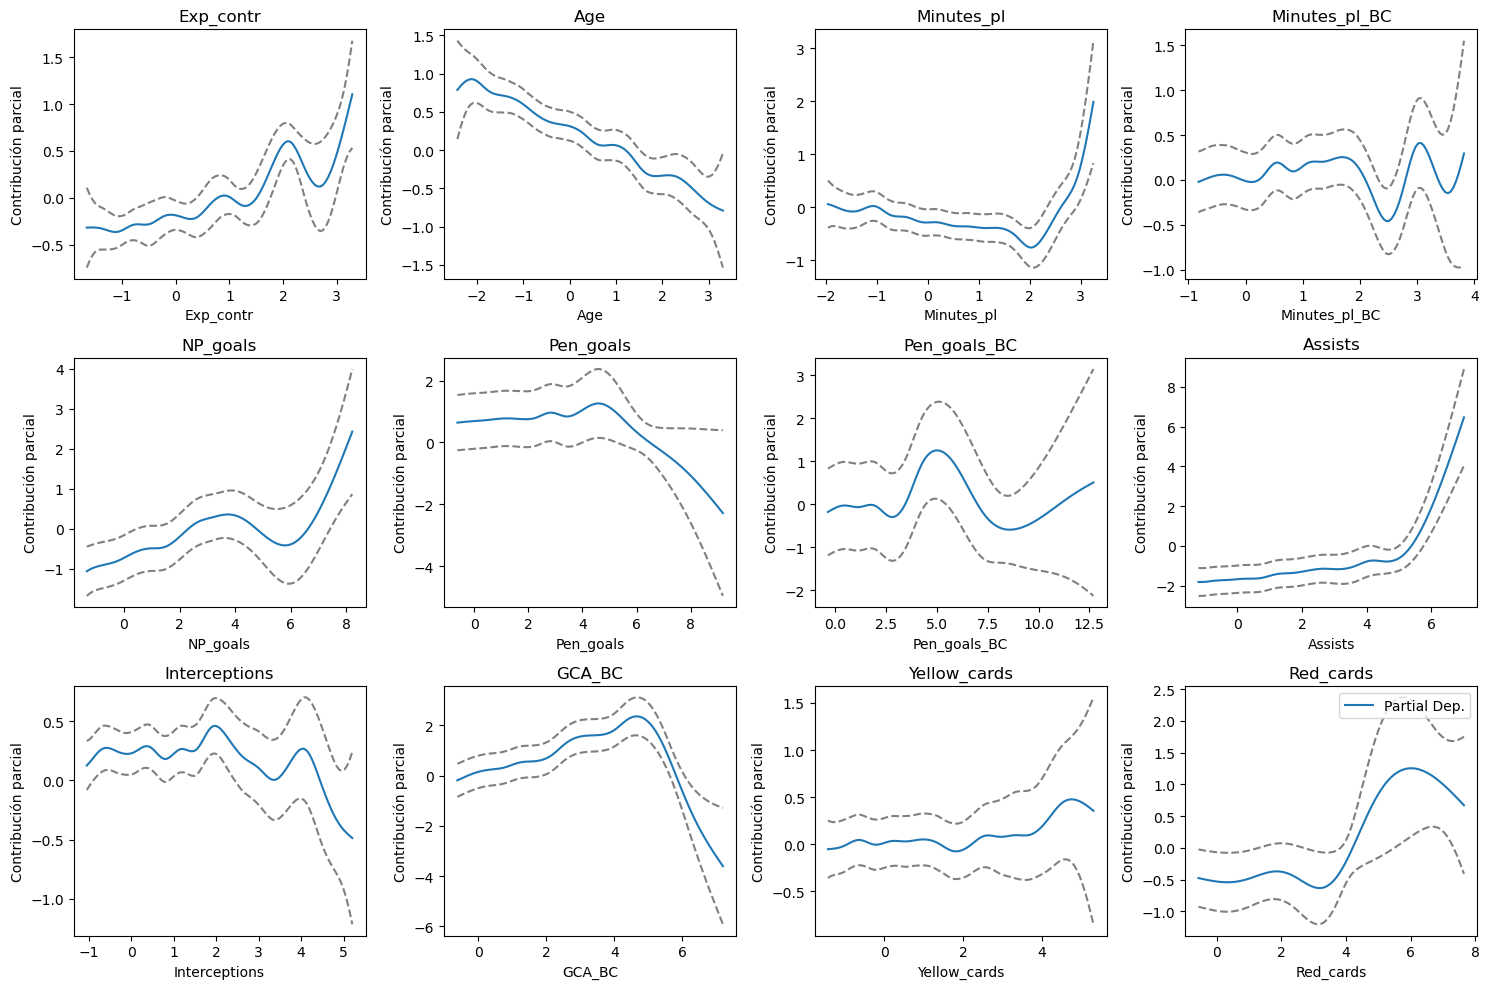

In [5]:
titles = ind_vars[:12]  # Usa los nombres de las primeras 12 variables

plt.figure(figsize=(15, 10))  # Ajusta tamaño del gráfico

for i in range(12):
    term = gam.terms[i]
    if isinstance(term, SplineTerm):  # Asegura que sea un spline
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        plt.subplot(3, 4, i + 1)
        plt.plot(XX[:, term.feature], pdep, label='Partial Dep.')
        plt.plot(XX[:, term.feature], confi[:, 0], c='gray', ls='--', label='95% CI' if i == 0 else "")
        plt.plot(XX[:, term.feature], confi[:, 1], c='gray', ls='--')
        plt.title(titles[i])
        plt.xlabel(titles[i])
        plt.ylabel('Contribución parcial')

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [6]:
p_values = gam.statistics_['p_values']

# Inicializar lista para guardar resultados
impacts = []

# Iterar sobre variables
for i in range(len(ind_vars)):
    if p_values[i] < 0.05:  # Filtrar por significancia estadística
        XX = gam.generate_X_grid(term=i)
        partial = gam.partial_dependence(term=i, X=XX)
        variance = np.var(partial)
        impacts.append((ind_vars[i], variance))

# Crear DataFrame ordenado por varianza descendente
impact_df = pd.DataFrame(impacts, columns=['Variable', 'Partial_Effect_Variance'])
impact_df = impact_df.sort_values('Partial_Effect_Variance', ascending=False)

print(impact_df)

                           Variable  Partial_Effect_Variance
7                           Assists                 3.782518
8                            GCA_BC                 2.083065
5                         Pen_goals                 0.849154
4                          NP_goals                 0.517235
6                      Pen_goals_BC                 0.270618
1                               Age                 0.250768
2                        Minutes_pl                 0.209425
0                         Exp_contr                 0.117307
3                     Minutes_pl_BC                 0.036623
13    Reduced_country_from_Portugal                 0.018120
9        Reduced_team_from_Paris SG                 0.014913
14      Reduced_country_from_Brasil                 0.009687
10  Reduced_country_from_Inglaterra                 0.006000
11     Reduced_country_from_Francia                 0.002006
12    Reduced_country_from_Alemania                 0.001694
